In [21]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare the data

In [22]:
L = 32
Directory = f"data/L_{L}"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

### Split train test ds

In [23]:
model_number = 9
times_number = 8

train_times = pd.read_csv(f'data/test_train_times/times_train_{times_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(f'data/test_train_times/times_test_{times_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
print(train_times,test_times)

[ 9 51 58 45  7 57 32  5 29  6  8 62 12 35 33 14 61 60 25 26 43 23 44 20
 11 59 41 10 55 28 24 21 16 42  2 34 38 39 31 52 13 53 17 22 27 40 36 49
 15] [47 46 54 56 19  3 48  1  4 30 37 18 50]


In [24]:
#init train ds
path_data = Directory+f'/input_ds_for_simple_nn_T{train_times[0]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
train_ds = nc_init['sample'][:].filled()

for t in train_times[1:]:
    path_data = Directory+f'/input_ds_for_simple_nn_T{t}_L_{L}.nc'
    nc_init = nc.Dataset(path_data)
    time_ds = nc_init['sample'][:].filled()
    train_ds = np.concatenate((train_ds, time_ds), axis=0)

In [25]:
#init test ds
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[0]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
test_ds = nc_init['sample'][:].filled()

for t in test_times[1:]:
    path_data = Directory+f'/input_ds_for_simple_nn_T{t}_L_{L}.nc'
    nc_init = nc.Dataset(path_data)
    time_ds = nc_init['sample'][:].filled()
    test_ds = np.concatenate((test_ds, time_ds), axis=0)

In [26]:
# split train and test ds in input-output datasets
input_train, output_train, input_val, output_val = train_ds[:,:len_in], train_ds[:,len_in:], test_ds[:,:len_in], test_ds[:,len_in:]
input_train.shape

(12544, 2256)

## Define the model

In [27]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.2, drop_prob2=0.3, drop_prob3=0.4, hidden_size1=1024, hidden_size2=512, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

In [28]:
learning_rate = 0.001
batch_size = 32
nb_epochs = 20
train_losses=[]
test_losses=[]
n_batches = input_train.shape[0]//batch_size

In [29]:
# train : convert numpy array to torch tensor
input = torch.from_numpy(input_train).float()
output = torch.from_numpy(output_train).float()

# test : convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()

## Use previous models

In [30]:
model_load = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
model_load.load_state_dict(torch.load(f'explo/models/simple_dnn{model_number}'))
model_load.eval()

DNN(
  (regression): Sequential(
    (0): Linear(in_features=2256, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=256, out_features=376, bias=True)
  )
)

In [31]:
# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()
tot_losses=0

model_load.eval()
# prediction
output_pred = model_load(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)

print('Test loss: {:.6f}'.format(loss))

Test loss: 0.078582


In [32]:
output_test.shape

torch.Size([3328, 376])

Plot the coarse grained heat flux (both predicted and real) from the reconstructed output and objective of the DNN.

t = 47


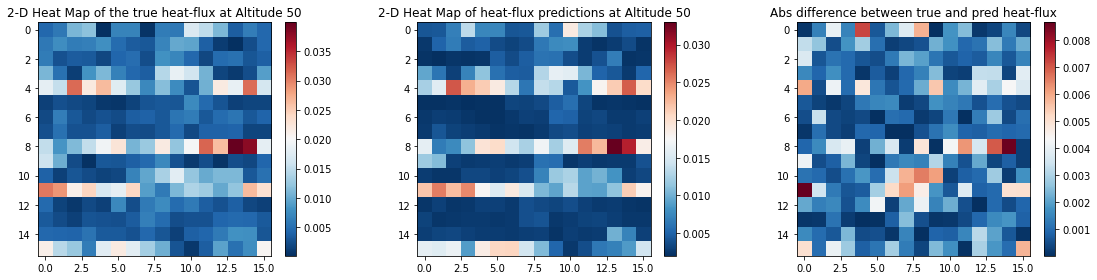

0.032957267 0.0019904096 0.007690647


In [33]:
t = 0
z=50
largeur = int(512/L)
pred_ds = output_pred[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()
true_ds = output_test[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()

#print(pred_ds)
print('t =',test_times[t])
utils.plot_output(pred_ds,true_ds,L,z,color='RdBu_r')

print(pred_ds[:,z].max(),pred_ds[:,z].min(), true_ds[:,z].mean())

Plot the coarse grained heat flux from Adrien's written nc files.

temperature mean,min,max: 3.107692055082101e-14 -0.025928363800019533 0.06368198776248349
wtheta mean,min,max : 0.007690647472325263 0.00011705226289217578 0.03993448963055981


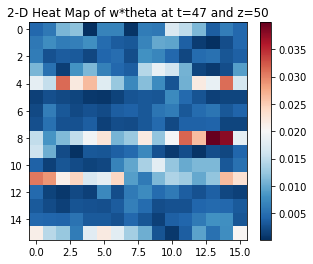

In [34]:
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[t]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
test_ds = nc_init['sample'][:].filled()[:,-len_out+z].reshape(16,16)
theta_ds = nc_init['sample'][:].filled()[:,3*len_out+z].reshape(16,16)
print('temperature mean,min,max:', theta_ds.mean(),theta_ds.min(),theta_ds.max())
print('wtheta mean,min,max :',test_ds.mean(),test_ds.min(),test_ds.max())
im = plt.imshow(test_ds , cmap = 'RdBu_r' , interpolation = 'nearest' )
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
plt.title(f"2-D Heat Map of w*theta at t={test_times[t]} and z={z}")
plt.show()

## Define baseline model

Baseline model : $\overline{w*\theta} \simeq \overline{w}*\overline{\theta}$

Comparison of objective heat flux, baseline heat flux and element wise difference of them.

In [35]:
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[t]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
time_ds = nc_init['sample'][:].filled()
time_ds[:,len_in:][:,z].shape

(256,)

47
Mean,min,max temperature fluctuation : 3.107692055082101e-14 -0.025928363800019533 0.06368198776248349
Mean,min,max true heat flux : 0.007690647472325263 0.00011705226289217578 0.03993448963055981
Mean,min,max baseline heat flux : 0.002810038635018621 -0.0065995156433784 0.030299148909679992


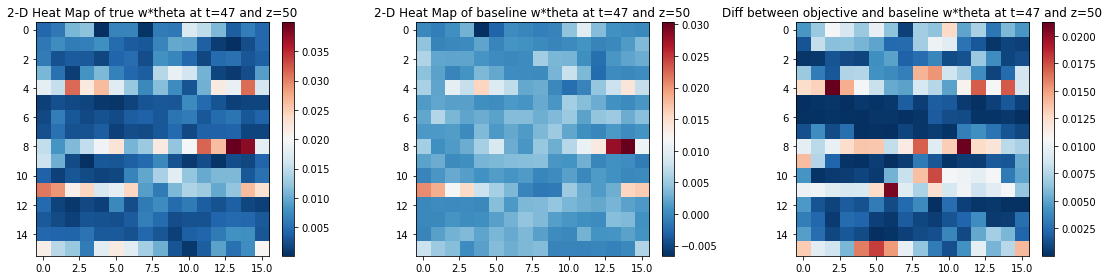

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

t=0
lz=376
#z=100     # equivalent to z=18 : first alt is 18
print(test_times[t])
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[t]}_L_32.nc'  #'data/L_32_new/input_ds_for_simple_nn_T10_L_32.nc'
nc_init = nc.Dataset(path_data)
true_heat_flux = nc_init[f'sample'][:].filled()[:,-len_out:][:,z].reshape(16,16)        # -len_out because : last len_out values are wtheta, z is wtheta at alt z

w_arr = nc_init[f'sample'][:].filled()[:,2*len_out:3*len_out][:,z].reshape(16,16)        # variables are [u,v,w,theta,s,tka,wtheta] so 2*len_out is w
theta_arr = nc_init[f'sample'][:].filled()[:,3*len_out:4*len_out][:,z].reshape(16,16)    # variables are [u,v,w,theta,s,tka,wtheta] so 3*len_out is theta
baseline_heat_flux = w_arr*theta_arr

print('Mean,min,max temperature fluctuation :',theta_arr.mean(),theta_arr.min(),theta_arr.max())
print('Mean,min,max true heat flux :',true_heat_flux.mean(),true_heat_flux.min(),true_heat_flux.max())
print('Mean,min,max baseline heat flux :',baseline_heat_flux.mean(),baseline_heat_flux.min(),baseline_heat_flux.max())

fig,axes = plt.subplots(1,3,figsize=(16,4))

im0 = axes[0].imshow(true_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
axes[0].set_title(f"2-D Heat Map of true w*theta at t={test_times[t]} and z={z}")

im1 = axes[1].imshow(baseline_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
axes[1].set_title(f"2-D Heat Map of baseline w*theta at t={test_times[t]} and z={z}")

im2 = axes[2].imshow(np.abs(true_heat_flux - baseline_heat_flux) , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
axes[2].set_title(f"Diff between objective and baseline w*theta at t={test_times[t]} and z={z}")

fig.tight_layout()
plt.show()

Problem : with $\theta$ and not $\theta'$, the baseline seems to be way closer to the objective than NN.

Normal vu que on utilise $\theta$ et non pas $\theta'$ donc on a $\theta \simeq 293K$ en permanence. On peut donc le considérer comme constant et $\overline{\theta} = \theta$, d'où $$\overline{w*\theta} = \overline{w*\overline{\theta}} =\overline{w}*\overline{\theta}$$

-> il faut considérer $\theta'$

Si on considère $\theta'$, on remarque que le baseline model approxime bien le flux de chaleur sur les zones où il n'y a quasi pas de flux (grandes zones) et mal sur les zones de fort flux (petites zones qui sont donc moyennées avec ce qui les entoure).

-> On peut faire mieux.

## Compare model and baseline

In [37]:
w_arr = nc_init[f'sample'][:].filled()[:,2*len_out:3*len_out].reshape(16,16,376)       # variables are [u,v,w,theta,s,tka,wtheta] so 2*len_out is w
theta_arr = nc_init[f'sample'][:].filled()[:,3*len_out:4*len_out].reshape(16,16,376)     # variables are [u,v,w,theta,s,tka,wtheta] so 3*len_out is theta

baseline_arr = w_arr*theta_arr
pred_arr = pred_ds.reshape(16,16,376)
true_arr = true_ds.reshape(16,16,376)

In [38]:
baseline_loss = 0
for i in range(16):
    for j in range(16):
        for a in range(376):
            baseline_loss += (true_arr[i,j,a] - baseline_arr[i,j,a])**2
            
pred_loss = 0
for i in range(16):
    for j in range(16):
        for a in range(376):
            pred_loss += (true_arr[i,j,a] - pred_arr[i,j,a])**2
            
print('baseline loss :',baseline_loss)
print('pred loss :', pred_loss)

baseline loss : 1.843042490266357
pred loss : 0.6156740070553477


Basline loss on 1 test time (256 samples) is $1.843042490266357$.

Model 8 loss on 1 test time (256 samples) is $0.5357984236829396$.

Model 9 loss on 1 test time (256 samples) is $0.61567400705534776$.

Model 8 is simple dnn with 3 hidden layers of size (1024, 512, 256) and a learning rate of $10^{-6}$. Trained for 400 epochs (no overfitting yet).

Model 9 is simple dnn with 3 hidden layers of size (1024, 512, 256) and an exp decaying learning rate starting at $10^{-5}$ and with $\gamma = 0.99$ until the 500th epoch : $lr = 6.6*10^{-8}$. Trained for 1000 epochs. Either lr too small after 500 epochs or we've reach the best we can do before overfitting.
